# install dependancies, takes around 45 seconds

Rendering Dependancies



In [2]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
#!pip install gym pyvirtualdisplay 2>&1
#!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Pacman Dependancies

# Imports and Helper functions


In [32]:
import sys, os, copy
from pathlib import Path
from a2c.a2c import *
#from torch.distributions import Categorical
proj_folder = Path('.').absolute()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
action_dist = Categorical(NeuralNet(nS, nA, activation=nn.Softmax(dim=1))(torch.randn((1,4))))
#
action = action_dist.sample()
action_logprob = action_dist.log_prob(action)
print(action, action_logprob)

tensor([0]) tensor([-0.5790], grad_fn=<SqueezeBackward1>)


# Run Simulations!

In [36]:
import argparse, matplotlib.pyplot as plt, tqdm
def parse_a2c_arguments():
    # Command-line flags are defined here.
    parser = argparse.ArgumentParser()
    parser.add_argument('--env-name', dest='env_name', type=str,
                        default='CartPole-v0', help="Name of the environment to be run.")   # 'LunarLander-v2'
    parser.add_argument('--num-episodes', dest='num_episodes', type=int,
                        default=3500, help="Number of episodes to train on.")    # 3500
    parser.add_argument('--lr', dest='lr', type=float,
                        default=5e-4, help="The actor's learning rate.")
    parser.add_argument('--use_a2c', dest='use_a2c', type=bool,
                        default=True, help="Use A2C")
    parser.add_argument('--use_baseline', dest='use_baseline', type=bool,
                        default=True, help="Use baseline model")
    parser.add_argument('--baseline-lr', dest='baseline_lr', type=float,
                        default=5e-4, help="The actor's learning rate.")
    parser.add_argument('--critic-lr', dest='critic_lr', type=float,
                        default=1e-4, help="The critic's learning rate.")
    parser.add_argument('--n', dest='n', type=int,
                        default=100, help="The value of N in N-step A2C.")

    parser_group = parser.add_mutually_exclusive_group(required=False)
    parser_group.add_argument('--render', dest='render',
                              action='store_true',
                              help="Whether to render the environment.")
    parser_group.add_argument('--no-render', dest='render',
                              action='store_false',
                              help="Whether to render the environment.")
    parser.set_defaults(render=False)

    return parser.parse_known_args()[0]    #.parse_args()
args = parse_a2c_arguments()
DEBUG=False

In [39]:
history, res = main_a2c(args)

Configurations:Namespace(baseline_lr=0.0005, critic_lr=0.0001, env_name='CartPole-v0', lr=0.0005, n=100, num_episodes=3500, render=False, use_a2c=True, use_baseline=True)


  0%|                                                  | 0/5 [00:00<?, ?it/s]

Seed:0


  0%|                                                  | 0/5 [00:00<?, ?it/s]

Episode: 0
Finished after 19 timesteps
(18,) (18,) (18,)


RuntimeError: The size of tensor a (2) must match the size of tensor b (18) at non-singleton dimension 1

In [23]:
#def main_a2c(args):
# Parse command-line arguments.
env_name = args.env_name

# Create the environment.
env =  wrap_env(gym.make(env_name))
nA = env.action_space.n
nS = env.observation_space.shape[0]
print(f"Configurations:{args}")

# Plot average performance of 5 trials
num_seeds = 5   # 5
eval_freq = 100  # 100
l = args.num_episodes//eval_freq
res = np.zeros((num_seeds, l))

gamma = 0.99
for i in tqdm.tqdm(range(num_seeds)):
    print(f"Seed:{i}")
    # Fix seed
    torch.manual_seed(i)
    np.random.seed(i)
    # save mean evaluation reward
    reward_means = []
    # TODO: create networks and setup reinforce/a2c
    history = dict.fromkeys(['train','test'],[])
    actor = NeuralNet(input_size=nS, output_size=nA, 
                      activation=nn.Softmax(dim=1))
    critic = NeuralNet(input_size=nS, output_size=1, 
                       activation=nn.LeakyReLU(0.9))
    A2C_net = A2C(actor=actor, actor_lr=args.lr, N=args.n, nA=nA, 
                  critic=critic, critic_lr=args.critic_lr, baseline=args.use_baseline, a2c=args.use_a2c)
    for m in range(args.num_episodes):
        print("Episode: {}".format(m))
        history['train'].append(A2C_net.train(env, gamma=gamma))
        if m % eval_freq == 0:
            print("[Policy Evaluation]")
            G = np.zeros(20)   # save 20 iterations of evaluation 
            for k in range(20):
                g = A2C_net.evaluate_policy(env)
                G[k] = g
            reward_mean = G.mean()
            reward_sd = G.std()
            print("The test reward for episode {0} is {1} with sd of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
            history['test'].append(G)
    res[i] = np.array(reward_means)

Configurations:Namespace(baseline_lr=0.0005, critic_lr=0.0001, env_name='CartPole-v0', lr=0.0005, n=100, num_episodes=3500, render=False, use_a2c=True, use_baseline=True)


  0%|                                                  | 0/5 [00:00<?, ?it/s]

Seed:0


  0%|                                                  | 0/5 [00:00<?, ?it/s]

Episode: 0
Finished after 17 timesteps


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

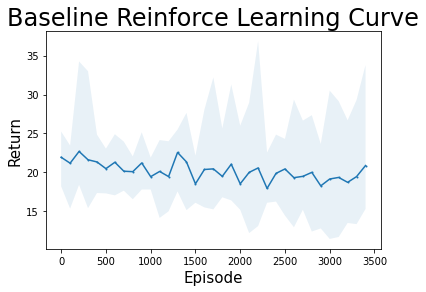

In [23]:
ks = np.arange(l)*100
avs = np.mean(res, axis=0)
maxs = np.max(res, axis=0)
mins = np.min(res, axis=0)

plt.fill_between(ks, mins, maxs, alpha=0.1)
plt.plot(ks, avs, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

if not os.path.exists('./plots'):
    os.mkdir('./plots')

if A2C_net.type == 'A2C' or A2C_net.type == 2:
    plt.title("A2C Learning Curve for N = {}".format(args.n), fontsize = 24)
    plt.savefig("./plots/a2c_curve_N={}.png".format(args.n))
elif A2C_net.type == 'Baseline' or A2C_net.type == 1:
    plt.title("Baseline Reinforce Learning Curve".format(args.n), fontsize = 24)
    plt.savefig("./plots/Baseline_Reinforce_curve.png".format(args.n))
elif A2C_net.type == 'Reinforce' or A2C_net.type == 0: # Reinforce
    plt.title("Reinforce Learning Curve", fontsize = 24)
    plt.savefig("./plots/Reinforce_curve.png")use_baseline